# **量子コンピュータワークショップ実践編（part2）**

## **初期設定**

このページを開いたらまず始めに "Copy to Drive" をクリックしてください。\
自分の Google Drive にこのファイルがコピーされます。

コピーができたらそのファイルを開いてください。\
以降はこのコピーしたファイル上で実行を行います。

**実行方法**

プログラムにカーソルをかざすと再生ボタンが出るのでそれをクリックしたら実行されます。\
また `Shift + Enter` でも実行できます。

## **Step1 古典計算：地図と車のGPSデータを用意**
オープンデータである OpenStreetmap と osmnx 、その他今回必要なパッケージがダウンロードされます。

In [1]:
# インストール
!git clone https://github.com/devel-system/QuantumAIWorkshop-20230228.git lib
!chmod +x lib/colab.sh
!lib/colab.sh

Cloning into 'lib'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 60 (delta 30), reused 47 (delta 17), pack-reused 0
Unpacking objects: 100% (60/60), 11.17 KiB | 317.00 KiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 7.0 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not current

In [2]:
# データのインポート
import numpy as np
from dimod import BinaryQuadraticModel
from neal import SimulatedAnnealingSampler
from dwave.cloud import Client
from dwave.system import DWaveSampler, EmbeddingComposite
from pyqubo import Binary

from lib.part2.congestion import get_noise_data, get_train_data, train, predict, show_congestion
from lib.part2.traffic_map import get_map_data, get_nearest_nodes, get_shortest_path, show_map_data

%matplotlib inline

## **Step2 古典計算：実行に必要なデータの入力**

ここでは実行を行うための初期値を設定します。

**初期値一覧**

|  名前     |  意味  |  変更可否  |
| -----    | ----- | ----- |
|  CITY    |  区または町  | ×  |
|  STATE   |  県  | ×  |
|  COUNTRY  |  国  | ×  |
|  START_POINT  |  各車のスタート地点（経度、緯度）  | ◯  |
|  GOAL_POINT  |  各車のゴール地点（経度、緯度）  | ◯  |
|  YOUBI  |  混雑予測を行う曜日。日、月、火、水、木、金、土 が選択可能です。  | ◯  |
|  TIME  |  混雑予測を行う日時。0:00 ~ 24:00 まで1時間単位で選択が可能です。  | ◯  |
|  CONGESTION  |  混雑か否かを判断する基準値（混雑度）。0以上50未満の値を設定することが可能です。  | ◯  |
|  CAR_NUMBER  |  走らせる車の台数。7台まで選択することが可能です。  | ◯  |
|  PATH_NUMBER  |  提案する経路の候補数。  | ◯  |
|  weight  |  制約条件のバイアス  | ×  |
|  SHOTS  |  観測の回数。通常は 1000 ~ 10000 の範囲で設定します。 | ◯  |
|  DWAVE_TOKEN  |  DWAVEのトークン。[DWave Leap](https://cloud.dwavesys.com/leap/)に登録して取得してください。トークンを入力するとDWave上の量子コンピュータが動きます。入力していない場合はシミュレータが動きます。  | ◯  |
|  DWAVE_DEVICE_NAME  |  DWaveで扱う量子コンピュータの名前。量子コンピュータの種類は [D-wave Leap](https://cloud.dwavesys.com/leap/) の Solvers に一覧があります。  | ◯  |

**デバイス一覧**
<table>
    <tr>
        <th>デバイス名</th>
        <td>Advantage_system5.3</td>
        <td>Advantage2_prototype1.1</td>
        <td>Advantage_system4.1</td>
        <td>Advantage_system6.1</td>
        <td>DW_2000Q_6</td>
    </tr>
    <tr>
        <th>量子ビット</th>
        <td>5615</td>
        <td>563</td>
        <td>5627</td>
        <td>5616</td>
        <td>2041</td>
    </tr>
    <tr>
        <th>トポロジー</th>
        <td>pegasus</td>
        <td>zephyr</td>
        <td>pegasus</td>
        <td>pegasus</td>
        <td>chimera</td>
    </tr>
</table>

In [10]:
# サンプリングデータ
DATA_NUMBER = 1000

# 地域を選択
CITY = 'Shibuya'
STATE = 'Tokyo'
COUNTRY = 'Japan'

# 固定（ startとgoalが決められている場合 ）
START_POINT = (139.7034496066092, 35.68385325806718)
GOAL_POINT = (139.7101434341499, 35.64834729700043)

# 曜日と日時と緩和する基準値を選択（基準値は0以上50未満）
YOUBI = '月'
TIME = '10:00'
CONGESTION = 30

# 車の台数と提案する経路数（車の台数は7台まで。）
CAR_NUMBER = 4
PATH_NUMBER = 5

# アニーリング設定
weight = 1000
SHOTS = 1000
DWAVE_TOKEN=""
DWAVE_DEVICE_NAME="DW_2000Q_6"

## **Step3 古典AI：混雑が起きている時間帯を特定**

曜日と時間帯から各道路の混雑度を学習・推定します。\
ここでは混雑度の予測を古典AI（回帰分析）を用いて行います。

[14:26:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:19.5589
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:17.9194
[2]	validation_0-rmse:16.4435
[3]	validation_0-rmse:15.1677
[4]	validation_0-rmse:13.9465
[5]	validation_0-rmse:12.8911
[6]	validation_0-rmse:11.9672
[7]	validation_0-rmse:11.112
[8]	validation_0-rmse:10.383
[9]	validation_0-rmse:9.71163
[10]	validation_0-rmse:9.09806
[11]	validation_0-rmse:8.57114
[12]	validation_0-rmse:8.12177
[13]	validation_0-rmse:7.75149
[14]	validation_0-rmse:7.15146
[15]	validation_0-rmse:6.62357
[16]	validation_0-rmse:6.15947
[17]	validation_0-rmse:5.92099
[18]	validation_0-rmse:5.53911
[19]	validation_0-rmse:5.34896
[20]	validation_0-rmse:5.05211
[21]	validation_0-rmse:4.9158
[22]	validation_0-rmse:4.67992
[23]	validation_0-rmse:4.46665
[24]	validation_0-rmse:4.28591
[25]	validation_0-rmse:4.18952
[26]	validation

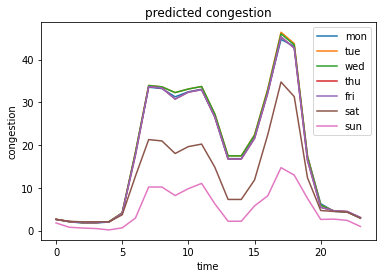

In [11]:
# 混雑度予測
noise_data = get_noise_data(DATA_NUMBER)
x_train, x_test, y_train, y_test = get_train_data(noise_data)
model = train(x_train, x_test, y_train, y_test)
show_congestion(model)

曜日: 月 日時: 10:00
混雑度（推定結果）: 32.4681


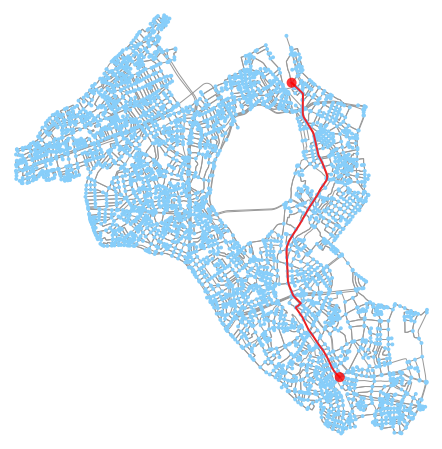

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb80de63940>)

In [12]:
# 条件の再確認
print("曜日:", YOUBI, "日時:", TIME)

# 推定
result = predict(model, YOUBI, TIME)
print("混雑度（推定結果）:", result)

# 経路を取得
G = get_map_data(CITY, STATE, COUNTRY)
start_node, goal_node = get_nearest_nodes(G, START_POINT, GOAL_POINT)
shotest_route, shotest_cost = get_shortest_path(G, start_node, goal_node, 1)
show_map_data(G, shotest_route)

## **Step4 古典計算：それぞれの車に対して、代わりのルートを決定。**

Step2で混雑が起きているルートの組に該当する車について考えます。\
該当する車は代わりのルートをいくつか提案します。（どのルートが一番混雑しないかはわかっていない。）

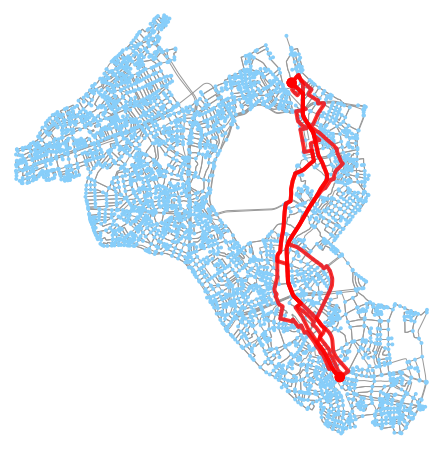

In [13]:
# 全経路と緩和後の経路を格納する変数
routes, costs = get_shortest_path(G, start_node, goal_node, PATH_NUMBER)
show_map_data(G, routes)
all_routes = [routes.copy() for i in range(CAR_NUMBER)]
all_routes_flat = sum(all_routes, [])
answer_routes = []

## **Step5 古典：混雑の最小化させる問題をQUBOの形に定式化**

## **Step6 古典 & 量子：QUBOの解を見つける（混雑が解消されるような代わりのルートを見つける）**
DWave社の量子アニーリングを用いて QUBO の解を見つけます。求めた解をもとに古典コンピュータで経路を決めます。\
Step2で `DWAVE_TOKEN` を入力している場合は実際の量子コンピュータが動きます。

Degree: 20
デバイス: DW_2000Q_6 (DWaveSampler)
結果
{'routes_0-0': 0, 'routes_0-1': 0, 'routes_0-2': 1, 'routes_0-3': 0, 'routes_0-4': 0, 'routes_1-0': 0, 'routes_1-1': 0, 'routes_1-2': 0, 'routes_1-3': 1, 'routes_1-4': 0, 'routes_2-0': 0, 'routes_2-1': 1, 'routes_2-2': 0, 'routes_2-3': 0, 'routes_2-4': 0, 'routes_3-0': 0, 'routes_3-1': 0, 'routes_3-2': 0, 'routes_3-3': 0, 'routes_3-4': 1}
Energy: -3600.0


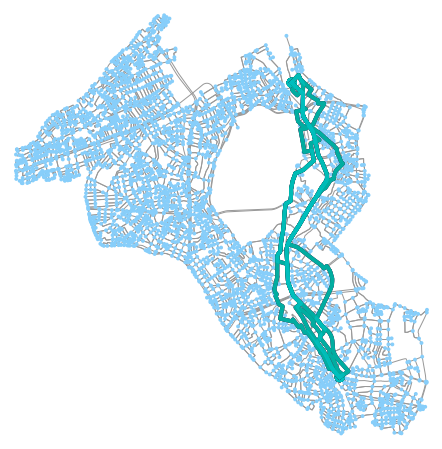

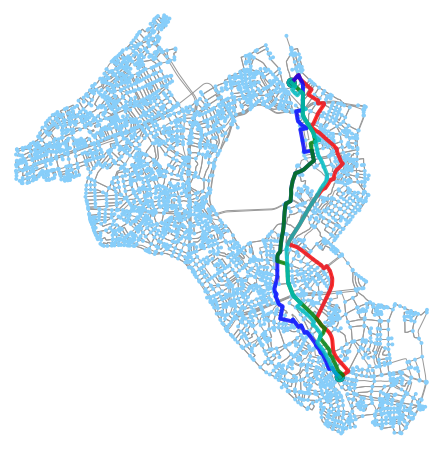

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb82c0517c0>)

In [14]:
# 混雑度判定
if result > CONGESTION:
    variables = [[Binary(f"routes_{j}-{i}") for i in range(len(all_routes[j]))] for j in range(CAR_NUMBER)]

    ################
    ###  Step5   ###
    ################
    PATH_list = []
    BASE_QUBO_Obj_list = []
    for i, routes in enumerate(all_routes):
        for j, route in enumerate(routes):
            for k in range(len(route)-1):
                p1 = route[k]
                p2 = route[k+1]
                if (p1, p2) in PATH_list:
                    BASE_QUBO_Obj_list[PATH_list.index((p1, p2))] += variables[i][j]
                elif (p2, p1) in PATH_list:
                    BASE_QUBO_Obj_list[PATH_list.index((p2, p1))] += variables[i][j]
                else:
                    PATH_list.append((p1, p2))
                    BASE_QUBO_Obj_list.append(variables[i][j])

    QUBO_Obj_list = [qubo ** 2 for qubo in BASE_QUBO_Obj_list]

    # QUBOの計算
    QUBO_Obj = sum(QUBO_Obj_list)
    QUBO_Penalty = sum([(sum(variables[i]) - 1) ** 2 for i in range(CAR_NUMBER)])
    QUBO = QUBO_Obj + weight * QUBO_Penalty

    ################
    ###  Step6   ###
    ################
    # 量子アニーリング
    qubo_model = QUBO.compile()
    qubo_compiled, offset = qubo_model.to_qubo()

    bqm = BinaryQuadraticModel.from_qubo(qubo_compiled)
    print(f"Degree: {len(bqm)}")

    if not DWAVE_TOKEN:
        sampler = SimulatedAnnealingSampler()
        device = "SimulatedAnnealingSampler"
    else:
        REGION = "eu-central-1" if DWAVE_DEVICE_NAME == "Advantage_system5.3" else "na-west-1"
        sampler = EmbeddingComposite(DWaveSampler(region=REGION, token=DWAVE_TOKEN, solver={"name": DWAVE_DEVICE_NAME}))
        device = sampler.properties['child_properties']['chip_id'] + " (DWaveSampler)"

    sampleset = sampler.sample_qubo(qubo_compiled, num_reads=SHOTS, label="Quamtum Annealing Part2")
    answer = sampleset.first.sample
    energy = sampleset.first.energy
    print("デバイス:", device)
    print(f"結果\n{answer}")
    print(f"Energy: {energy}")

    # 経路マッピング
    for i, (k, v) in enumerate(answer.items()):
        if v == 1:
            answer_routes.append(all_routes_flat[i])

else:
    # ランダムに経路を選択
    for i in range(CAR_NUMBER):
        answer_routes.append(routes[np.random.randint(0, len(routes))])

color_list = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
route_colors = [color_list[i] for i in range(CAR_NUMBER) for j in range(PATH_NUMBER)]

show_map_data(G, all_routes_flat, route_colors)
show_map_data(G, answer_routes, color_list[0:CAR_NUMBER])

---
## <small>教材作成</small>
<small>DEVEL株式会社</small>